# Now lets make a base line with TF-IDF and Some Regression model

In [227]:
from paths import DATA_PATH
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from pymystem3 import Mystem
import nltk
import re
nltk.download("stopwords")
from nltk.corpus import stopwords
russian_stopwords = stopwords.words("russian")

import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.svm import SVR

from scipy import sparse

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ruslansirazhetdinov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [205]:
df = pd.read_csv(DATA_PATH / 'news_stocks.csv').reindex(index=df.index[::-1]).reset_index(drop=True)
df

,date,title,text,link,author,label,open,high,low,close,volume
0,2022-05-08,Заявки на транзит российского газа через Украи...,На уровне более 90 миллионов кубометров заявки...,https://www.finam.ru/publications/item/zayavki...,РИА Новости,positive,124.30,126.41,120.90,121.11,580965.0
1,2022-05-08,Юань - хороший инструмент для хеджирования рис...,Ввиду сильной экономики Китая юань менее подве...,https://www.finam.ru/publications/item/yuan-xo...,"Жильников Егор, ""Промсвязьбанк""",positive,124.30,126.41,120.90,121.11,580965.0
2,2022-05-08,"""Сбербанк"" увеличил сумму кредита по ипотеке с...",Сумма кредита по ипотеке с господдержкой увели...,https://www.finam.ru/publications/item/sberban...,Finam.ru,positive,124.30,126.41,120.90,121.11,580965.0
3,2022-05-08,Постпреды ЕС в воскресенье не достигли соглаше...,Венгрия продолжает блокировать предложение Евр...,https://www.finam.ru/publications/item/postpre...,РИА Новости,negative,124.30,126.41,120.90,121.11,580965.0
4,2022-05-08,Реальные доходы россиян в 2022 году могут упас...,По отношению к пиковому 2013 году реальные рас...,https://www.finam.ru/publications/item/realnye...,"Суворов Евгений, банк ""ЦентроКредит""",negative,124.30,126.41,120.90,121.11,580965.0
...,...,...,...,...,...,...,...,...,...,...,...
30609,2023-05-06,Результаты Ford по итогам прошедшего года можн...,Компания явно демонстрирует постепенное урегул...,https://www.finam.ru/publications/item/rezulta...,"Поздняков Дмитрий, Freedom Finance Global",positive,235.83,240.93,233.42,237.06,11352.0
30610,2023-05-06,"Банки США - депозиты сокращаются, кредиты растут",Ребалансировка балансов банков продолжается,https://www.finam.ru/publications/item/banki-s...,Сусин Егор,negative,235.83,240.93,233.42,237.06,11352.0
30611,2023-05-06,"Закрытие дивидендного реестра по ""Сбербанку"" с...",Последний день с рекордными дивидендами акции ...,https://www.finam.ru/publications/item/zakryti...,"Кожухова Елена, ИК ""Велес Капитал""",positive,235.83,240.93,233.42,237.06,11352.0
30612,2023-05-06,Встреча по зерновой сделке на уровне заместите...,"Встреча пройдет с участием России, Украины, Ту...",https://www.finam.ru/publications/item/vstrech...,Finam.ru,positive,235.83,240.93,233.42,237.06,11352.0


# Соединяем заголовок с самой новостью, лемматизируем слова

In [206]:
title_texts = df.title.fillna('') + df.text.fillna('')

In [183]:
def normalize_text(df):
    re_word = re.compile(r'\b[^\d\W]+\b')
    texts = df.str.lower()
    mystem = Mystem()
    texts.dropna(inplace=True)
    texts = texts.apply(lambda line: ' '.join(re.findall(re_word, line)))
    texts = texts.apply(lambda line: ' '.join(filter(lambda x: x not in russian_stopwords, mystem.lemmatize(line))))

    return texts

normalized_news = normalize_text(title_texts)

In [207]:
normalized_news

0        заявка     транзит   российский   газ     укра...
1        юань   хороший   инструмент     хеджирование  ...
2        сбербанк   увеличивать   сумма   кредит     ип...
3        постпред   ес     воскресение     достигать   ...
4        реальный   доход   россиянин     год   мочь   ...
                               ...                        
30609    результат   ford     итог   прошедший   год   ...
30610    банк   сша   депозит   сокращаться   кредит   ...
30611    закрытие   дивидендный   реестр     сбербанк  ...
30612    встреча     зерновой   сделка     уровень   за...
30613    инвестор     сильно   верить     дефолт   сша ...
Length: 30614, dtype: object

In [350]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(normalized_news)
X

<30614x16507 sparse matrix of type '<class 'numpy.float64'>'
	with 493169 stored elements in Compressed Sparse Row format>

In [351]:
def shift_left(l, days=30):
    last = l[-1]
    rolled = np.roll(l, -days)
    rolled[-days:] = last
    return rolled

In [352]:
X = sparse.hstack([X, shift_left(df.open.values, len(df)//365*30)[:,np.newaxis]]).tocsr()
X

<30614x16508 sparse matrix of type '<class 'numpy.float64'>'
	with 523783 stored elements in Compressed Sparse Row format>

In [353]:
y = df.close

# Работаем с временным рядом - поэтому делим без перемешивания

In [354]:
test_size = 0.22
n_samples = X.shape[0]


X_train = X[:n_samples - int(n_samples * test_size)]
y_train = y[:n_samples - int(n_samples * test_size)]
X_test = X[-int(n_samples * test_size):]
y_test = y[-int(n_samples * test_size):]

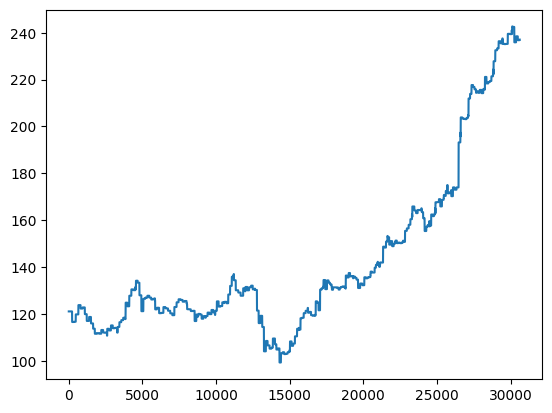

In [355]:
plt.plot(y)

In [324]:
def running_mean(x, N,mode='valid'):
    return np.convolve(x, np.ones((N,))/N, mode=mode)

def test_model(reg, moving_average=None):
    reg.fit(X_train, y_train)
    y_test_pred = reg.predict(X_test)
    print('Test MSE', mean_squared_error(y_test, y_test_pred))
    print('Test MAPE', mean_absolute_percentage_error(y_test, y_test_pred))
    y_pred = reg.predict(X)
    if moving_average:
        y_pred = running_mean(y_pred, moving_average)
        
        y_test_pred_smooth = running_mean(y_test_pred, moving_average, mode='same')
        print('Smoothed Test MSE', mean_squared_error(y_test, y_test_pred_smooth))
        print('Smoothed Test MAPE', mean_absolute_percentage_error(y_test, y_test_pred_smooth))
    fig, ax = plt.subplots(1,1, dpi=300)
    train_size = len(y_train)
    y_pred = pd.Series(y_pred)
    ax.plot(y, label='true')
    ax.plot(y_pred, label='pred')
    ax.set_ylim((y.min()-10, y.max()+10))
    plt.axvline(x=train_size, c='r', linestyle='--')
    ax.legend()
    return reg

Test MSE 6286.509789950884
Test MAPE 0.35054862206972986
Smoothed Test MSE 6290.722645476591
Smoothed Test MAPE 0.3510451480675718


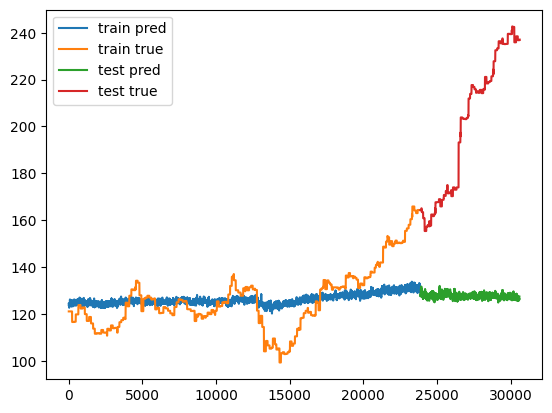

In [194]:
model = test_model(linear_model.RidgeCV(alphas=np.logspace(-6, 6, 13), cv=2), moving_average=50)

In [28]:
model.alpha_

10.0

Test MSE 1320.384568280803
Test MAPE 0.12920500837918455
Smoothed Test MSE 1477.273768045424
Smoothed Test MAPE 0.1343370067667638


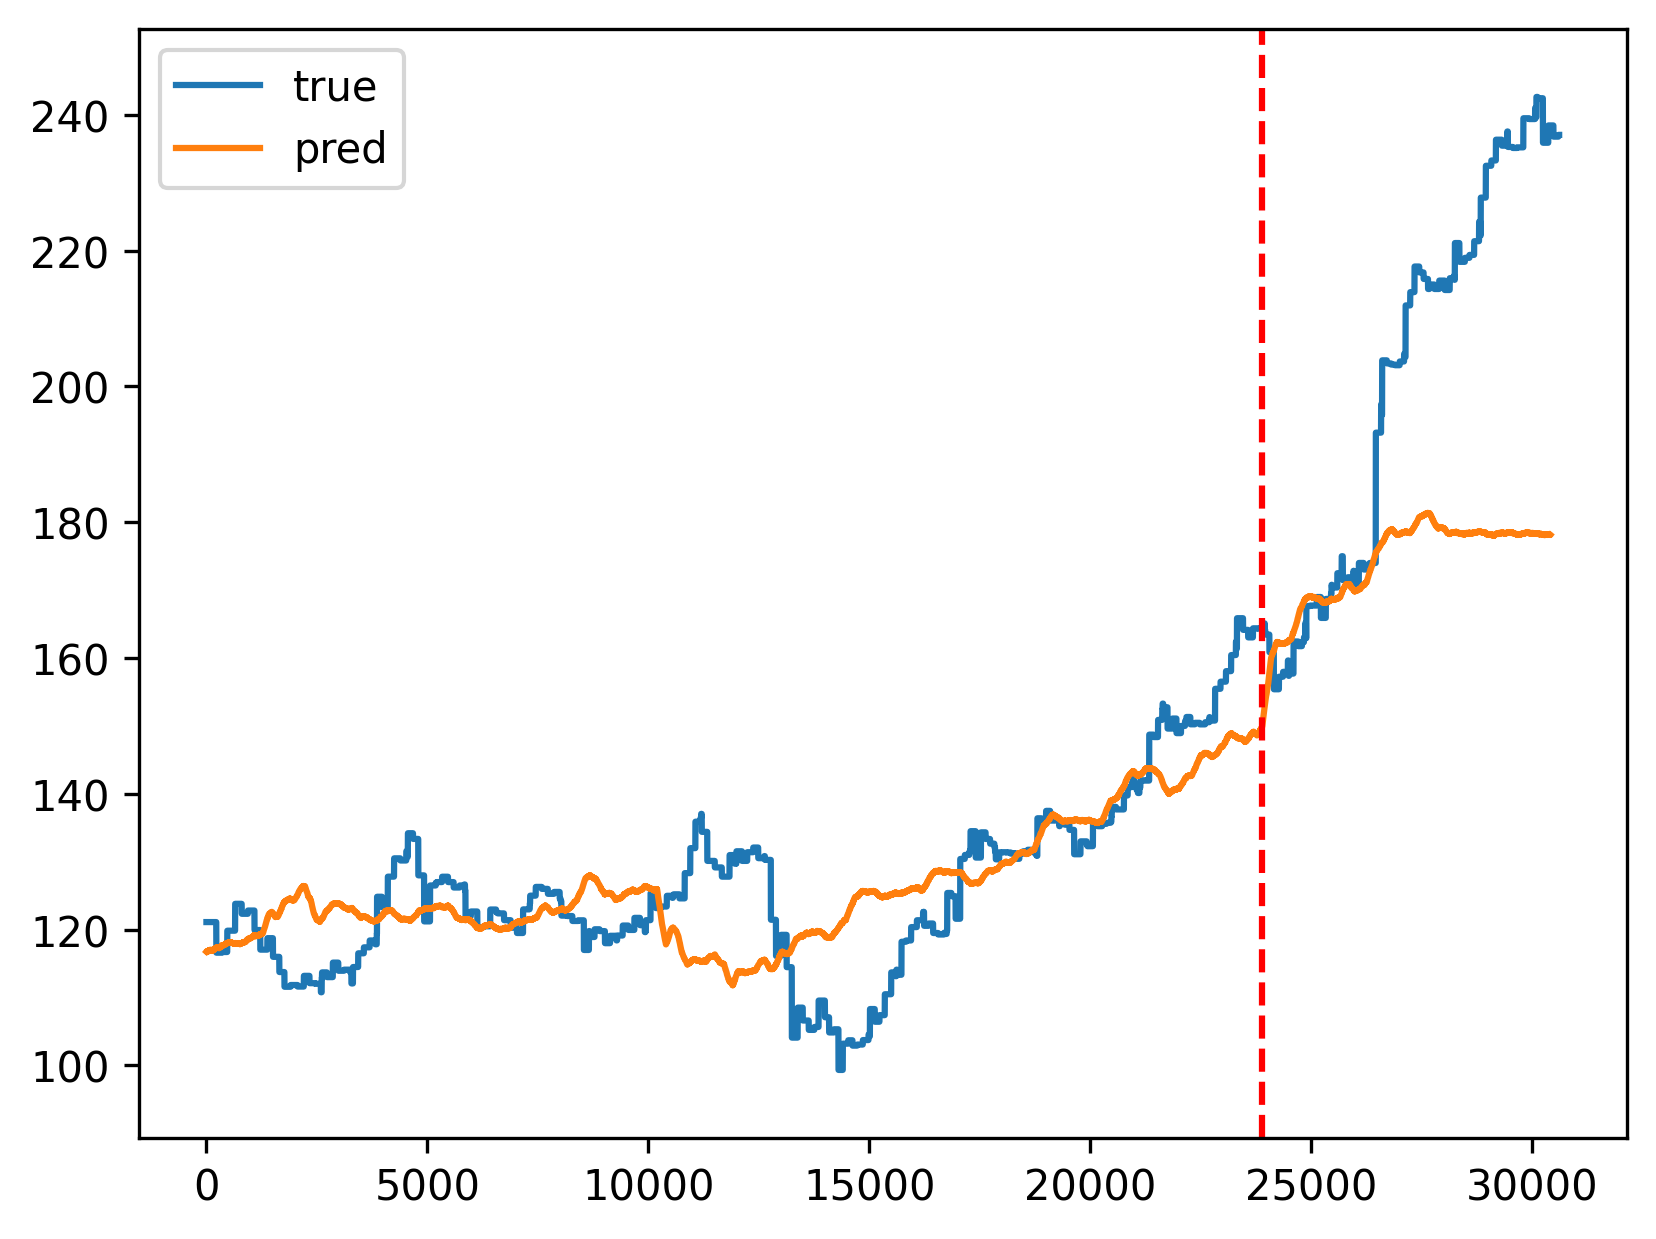

In [356]:
model = test_model(linear_model.Ridge(alpha=10), moving_average=200)

Test MSE 1320.384568280803
Test MAPE 0.12920500837918455
Smoothed Test MSE 1324.765016716537
Smoothed Test MAPE 0.1287015332876034


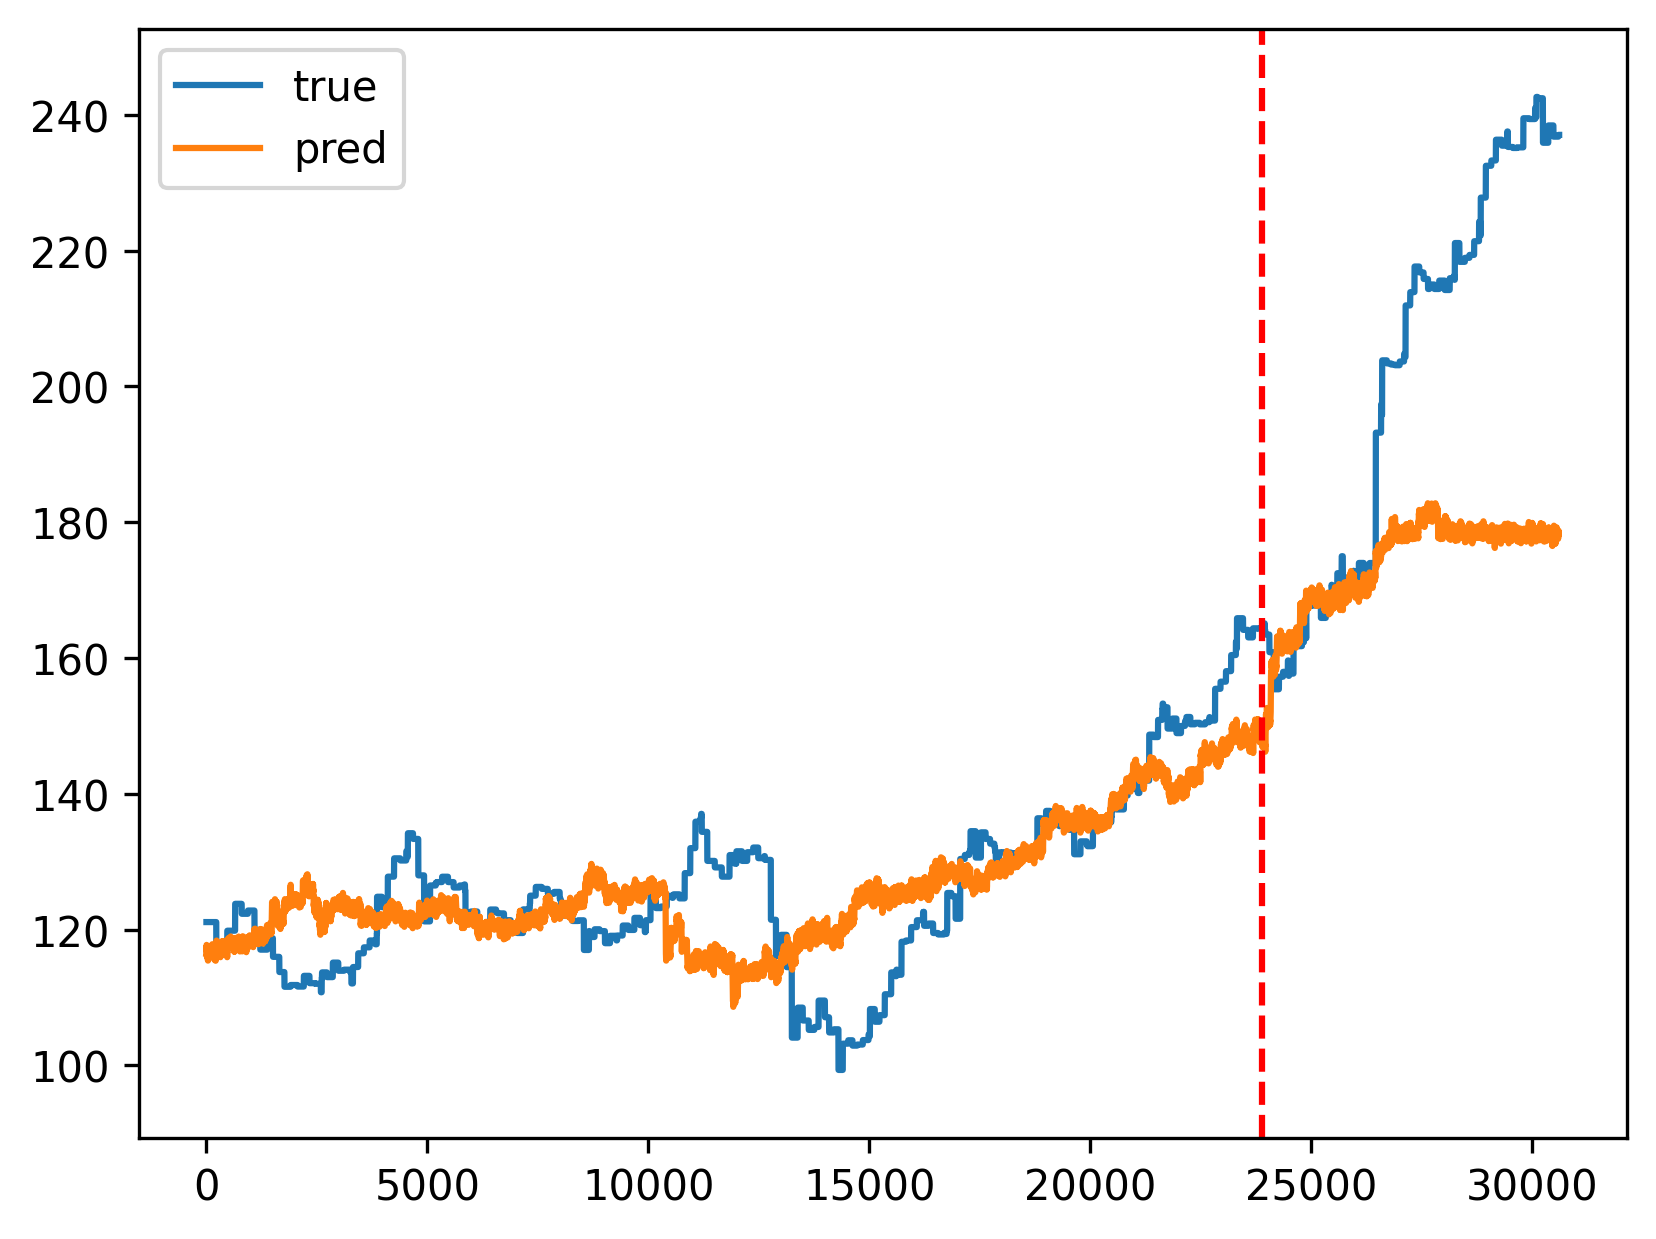

In [362]:
model = test_model(linear_model.Ridge(alpha=10), moving_average=10)

Test MSE 1253.3769710079387
Test MAPE 0.12530471407855318


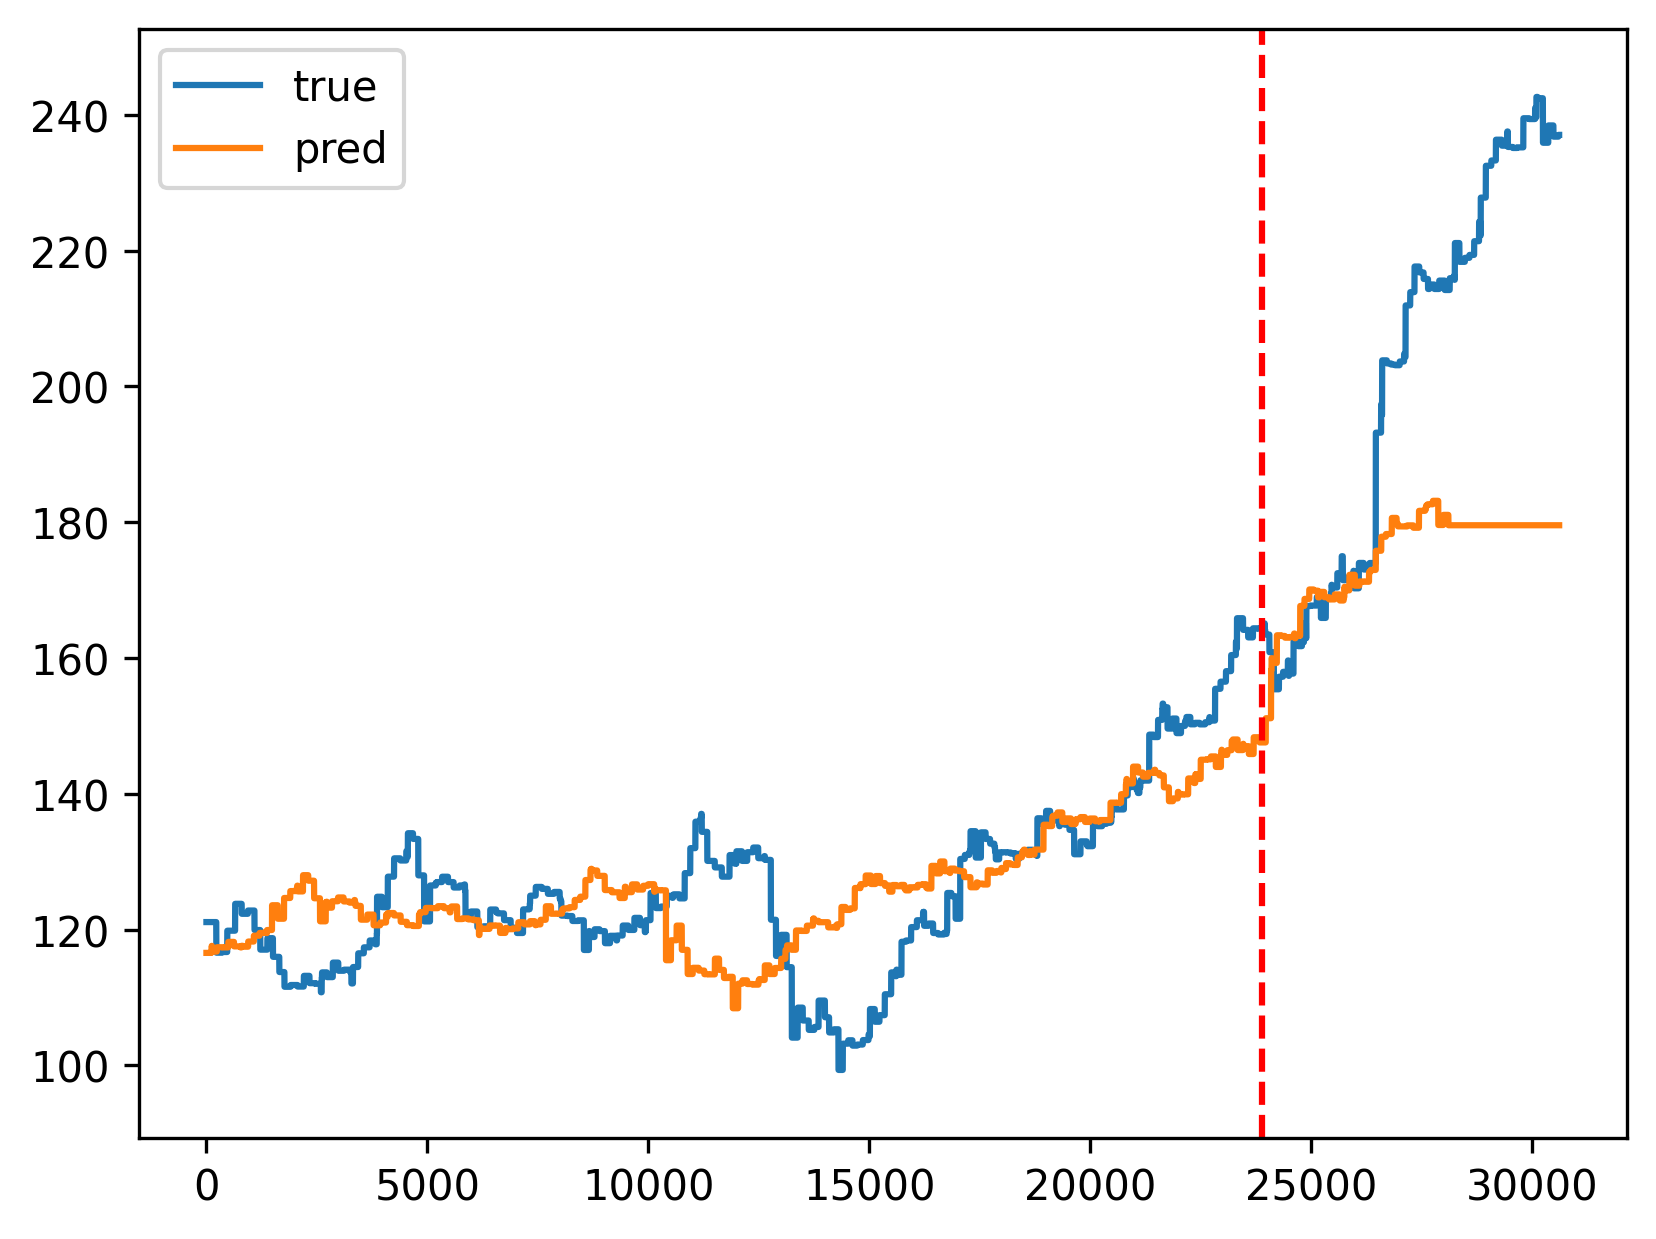

In [363]:
model = test_model(linear_model.Lasso(alpha=0.1), moving_average=None)

Test MSE 6456.908120022614
Test MAPE 0.3564744933310639
Smoothed Test MSE 6493.686829696592
Smoothed Test MAPE 0.35769444421351293


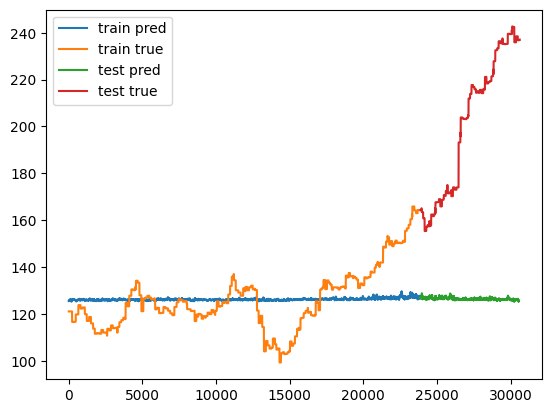

In [201]:
param_grid = {
    'max_depth': [10, 100, 1000, None],
    'max_features': [10, 100, 500, None],
    'min_samples_leaf': [1, 2, 3, 10, 20],
}

model = test_model(
    GridSearchCV(
        estimator=tree.DecisionTreeRegressor(
            random_state=42,
        ),
        param_grid=param_grid,
        cv=TimeSeriesSplit(n_splits=2),
    ),
    moving_average=50,
)

In [142]:
model.best_params_

{'max_depth': 10, 'max_features': 500, 'min_samples_leaf': 20}

Test MSE 6287.967843451857
Test MAPE 0.3503865567315228
Smoothed Test MSE 6344.584319483645
Smoothed Test MAPE 0.3528179197452177


DecisionTreeRegressor(max_depth=10, max_features=500, min_samples_leaf=20,
                      random_state=42)

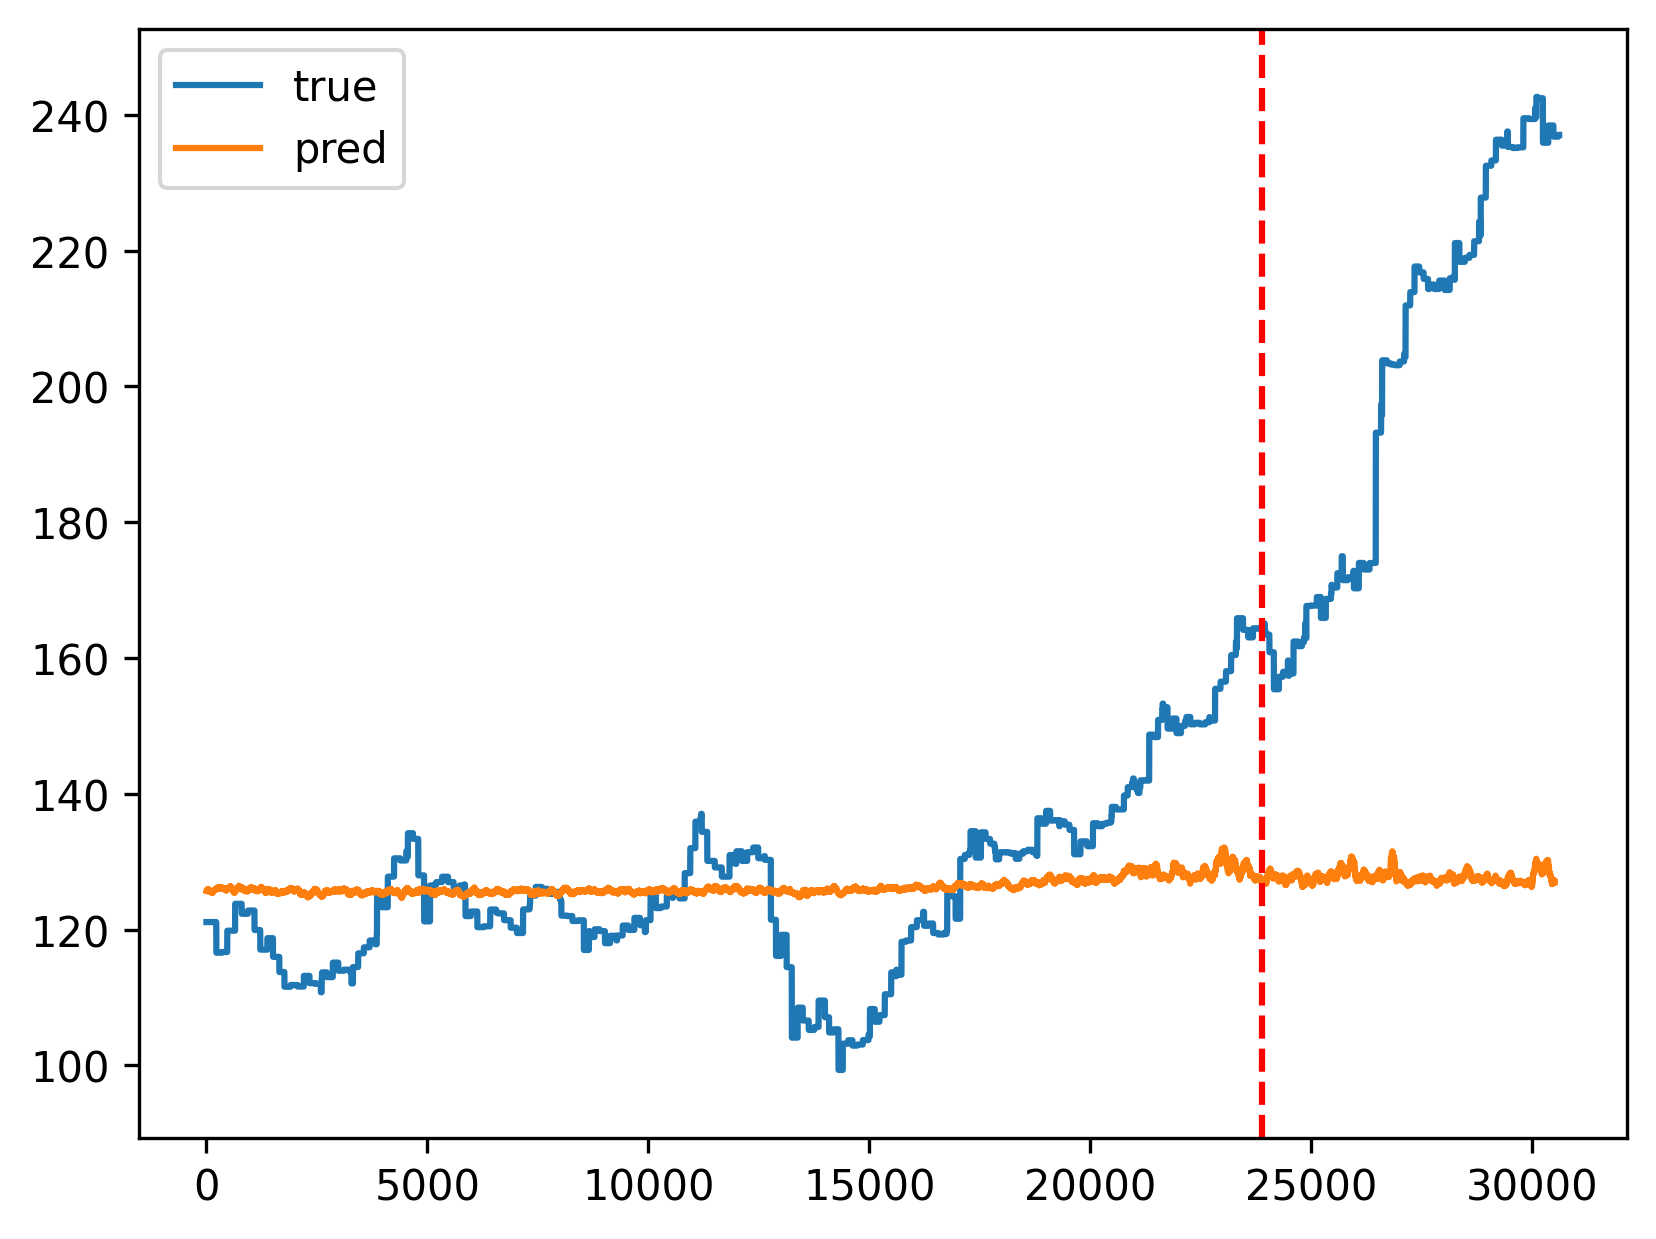

In [365]:
test_model(
    tree.DecisionTreeRegressor(
        **model.best_params_,
        random_state=42,
    ),
    moving_average=100,
)

## Lest set a baseline 

Test MSE 6286.509789950884

Test MAPE 0.35054862206972986